In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
### keyword argument 찾기
import inspect
inspect.signature(sns.residplot)

<Signature (*, x=None, y=None, data=None, lowess=False, x_partial=None, y_partial=None, order=1, robust=False, dropna=True, label=None, color=None, scatter_kws=None, line_kws=None, ax=None)>

In [66]:
loans_df = pd.read_csv('data/loans.csv')

# total_credit_limit
# total_credit_utilized

### ch9에서 활용하는 column만 추출
intro_data = loans_df[['interest_rate','verified_income','debt_to_income', 'total_credit_limit', 'total_credit_utilized', 'public_record_bankrupt','term','issue_month','inquiries_last_12m']]

# credit_util 항목 만들기
intro_data['credit_util'] = np.round(intro_data['total_credit_utilized']/intro_data['total_credit_limit'],2)

### 이름변경
intro_data.columns = ['interest_rate', 'income_ver', 'debt_to_income', '1','2', 'bankruptcy', 'term', 'issued','credit_checks','credit_util']

# loans_df.loc[1]
intro_data.drop(columns=['1','2'],inplace=True)


intro_data.dropna(inplace=True) # 결측값 있는 row 제거

<ipython-input-66-0ec42897e913>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intro_data['credit_util'] = np.round(intro_data['total_credit_utilized']/intro_data['total_credit_limit'],2)
<ipython-input-66-0ec42897e913>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  intro_data.drop(columns=['1','2'],inplace=True)
<ipython-input-66-0ec42897e913>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-

In [75]:
### Residual 찾기
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder

raw_data = intro_data.drop(columns=['interest_rate','issued']).reset_index(drop=True) # y값, 불필요한 값 제거 후 index 재설정
target = intro_data['interest_rate'] # y값

### verified income encoding
encoder = OneHotEncoder(sparse=False) # Sparse =False 해야 행렬반환
encoded = encoder.fit_transform(raw_data[['income_ver']]) 
encoder_fit = pd.DataFrame(encoded, columns=encoder.categories_[0]) # dataframe으로 만들기

data = raw_data.join(encoder_fit).drop(columns=['income_ver']) # encoding 결과 합쳐서 최종 data 만들기

#training model
model = LinearRegression()
model.fit(data,target)

LinearRegression()

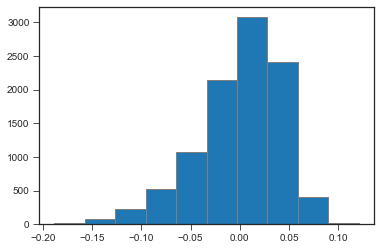

In [76]:
hat_y = model.predict(data)
residual = hat_y - target # residual = fit - data
residual = residual/100
plt.hist(residual, edgecolor='grey')
plt.show()

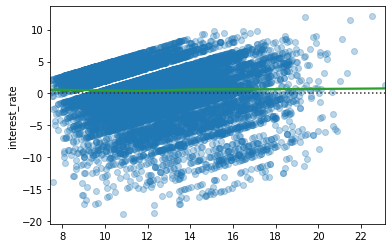

In [9]:
# 완성한 모델 residual 빈도수 histogram으로 확인
hat_y = model.predict(data)
residual = hat_y - target # residual = fit - data
sns.residplot(x= hat_y,y=hat_y-target,lowess=True,scatter_kws={'alpha': 0.3}, line_kws={'color':'tab:green'})
plt.show()

Text(0, 0.5, 'Residual')

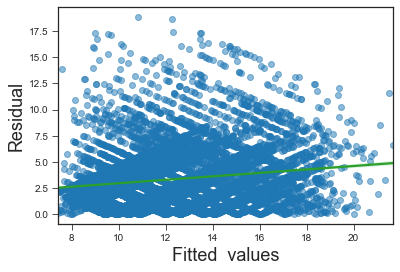

In [69]:
plt.style.use('seaborn-ticks')

set_data = pd.DataFrame([hat_y,abs(residual)]).T[hat_y < 22]


# ax_1 = plt.scatter(x=set_data[0], y=set_data[1],alpha=0.5)
sns.regplot(x=set_data[0], y=set_data[1], scatter_kws={'alpha':0.5, 'color' : 'tab:blue'}, line_kws={'color' : 'tab:green'})
plt.xlabel('Fitted  values', fontsize= 18)
plt.ylabel('Residual', fontsize= 18)


In [13]:
raw_data.columns

Index(['income_ver', 'debt_to_income', 'bankruptcy', 'term', 'credit_checks',
       'credit_util'],
      dtype='object')

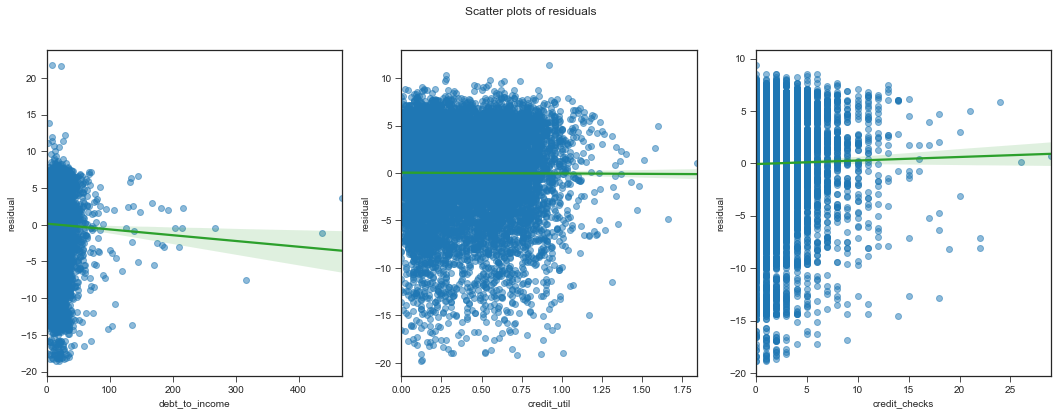

In [81]:
scat_col = ['debt_to_income','credit_util','credit_checks']
fig, axes = plt.subplots(1,3, figsize=(18,6))
for num, col in enumerate(scat_col) : 
    model = LinearRegression()
    model.fit(raw_data[[col]],target)
    hat_y = model.predict(raw_data[[col]])
    residual = hat_y - target 
    set_data = pd.DataFrame([raw_data[col],residual]).T
    set_data.columns = [col,'residual']
    sns.regplot(ax= axes[num],x=set_data[col], y=set_data['residual'], scatter_kws={'alpha':0.5, 'color' : 'tab:blue'}, line_kws={'color' : 'tab:green'},ci=95) # confidence interval 
    fig.suptitle('Scatter plots of residuals ')


C:\Users\679oo\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


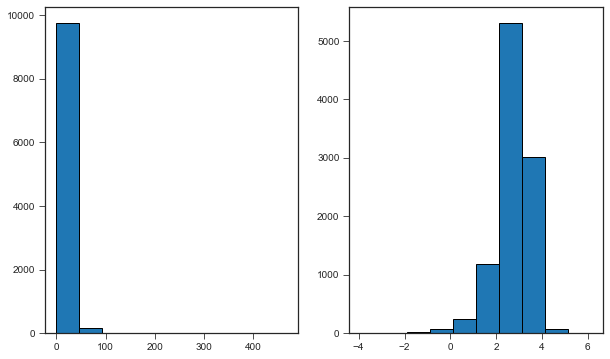

In [49]:
plt.figure(figsize=(10,6))
scat_col = data['debt_to_income']
a = np.log(scat_col) # 
b = [b for b in a if b !=float('-inf') ]
plt.subplot(1,2,1)
plt.hist(scat_col,edgecolor='black')
plt.subplot(1,2,2)
plt.hist(b,edgecolor='black')
plt.show()



C:\Users\679oo\anaconda3\lib\site-packages\pandas\core\arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-72-9c4c751401ab>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_data['log_debt'] = np.log(new_data['debt_to_income'])


<AxesSubplot:xlabel='log_debt', ylabel='interest_rate'>

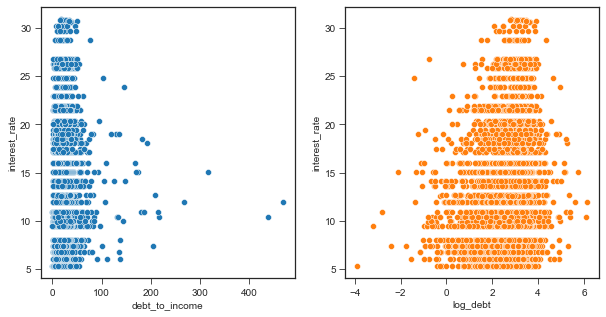

In [72]:
new_data = intro_data[['interest_rate','debt_to_income']]
new_data['log_debt'] = np.log(new_data['debt_to_income'])
final_data = new_data[new_data['log_debt'] != float('-inf')]

fig,axes = plt.subplots(1,2, figsize=(10,5))
sns.scatterplot(data=final_data, x='debt_to_income', y='interest_rate', ax=axes[0])
sns.scatterplot(data=final_data, x='log_debt', y='interest_rate', ax=axes[1],color='tab:orange')


In [80]:
new_data = intro_data[['interest_rate','debt_to_income']]
new_data.corr()

,interest_rate,debt_to_income
interest_rate,1.000000,0.141934
debt_to_income,0.141934,1.000000
